# Практика

```py
class NeuralNetwork:
    def __init__(self, modules):
        '''
        Constructs network with *modules* as its layers
        '''
        self.modules = modules

    def forward(self, X):
        y = X
        for i in range(len(self.modules)):
            y = self.modules[i].forward(y)
        return y

    def backward(self, dLdy):
        '''
        dLdy here is a gradient from loss function
        '''
        for i in range(len(self.modules))[::-1]:
            dLdy = self.modules[i].backward(dLdy)

    def step(self, learning_rate):
        for i in range(len(self.modules)):
            self.modules[i].step(learning_rate)
```

по сути нужно реализовать так, чтобы в for всё вызвать

In [ ]:
import numpy as np

class Linear:
    def __init__(self, input_size, output_size):
        '''
        Creates weights and biases for linear layer.
        Dimention of inputs is *input_size*, of output: *output_size*.
        '''
        #### YOUR CODE HERE
        #### Create weights, initialize them with samples from N(0, 0.1).
        self.W = np.random.randn(input_size, output_size)*0.01  # TODO N(0, 0.1) — нормальное распределение со стандартным отклонением 0.1
        self.b = np.zeros(output_size)

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, input_size).
        Returns output of size (N, output_size).
        Hint: You may need to store X for backward pass
        '''
        self.X = X
        return X.dot(self.W)+self.b

    def backward(self, dLdy):
        '''
        1. Compute dLdw and dLdx.
        2. Store dLdw for step() call
        3. Return dLdx
        '''
        self.dLdW = self.X.T.dot(dLdy)
        self.dLdb = dLdy.sum(0)
        self.dLdx = dLdy.dot(self.W.T)
        return self.dLdx

    def step(self, learning_rate):
        '''
        1. Apply gradient dLdw to network:
        w <- w - learning_rate*dLdw
        '''
        self.W = self.W - learning_rate * self.dLdW
        self.b = self.b - learning_rate * self.dLdb

class Sigmoid:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.s = 1./(1+np.exp(-X))
        return self.s

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return self.s*(1-self.s)*dLdy

    def step(self, learning_rate):
        pass

class NLLLoss:
    def __init__(self):
        '''
        Applies Softmax operation to inputs and computes NLL loss
        '''
        pass

    def forward(self, X, y):
        '''
        Passes objects through this layer.
        X is np.array of size (N, C), where C is the number of classes
        y is np.array of size (N), contains correct labels
        '''
        self.p = np.exp(X)
        self.p /= self.p.sum(1, keepdims=True)
        self.y = np.zeros((X.shape[0], X.shape[1]))
        self.y[np.arange(X.shape[0]), y] = 1
        return -(np.log(self.p)*self.y).sum(1).mean(0)

    def backward(self):
        '''
        Note that here dLdy = 1 since L = y
        1. Compute dLdx
        2. Return dLdx
        '''
        return (self.p - self.y) / self.y.shape[0]


class NeuralNetwork:
    def __init__(self, modules):
        '''
        Constructs network with *modules* as its layers
        '''
        self.modules = modules

    def forward(self, X):
        y = X
        for i in range(len(self.modules)):
            y = self.modules[i].forward(y)
        return y

    def backward(self, dLdy):
        '''
        dLdy here is a gradient from loss function
        '''
        for i in range(len(self.modules))[::-1]:
            dLdy = self.modules[i].backward(dLdy)

    def step(self, learning_rate):
        for i in range(len(self.modules)):
            self.modules[i].step(learning_rate)


# Работа с MNIST

Воспользуемся написанной нейронной сетью для решения задачи распознавания рукописных цифр. Также мы исследуем, как влияет выбор нелинейности и предобработка данных на качество классификации.

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [4]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
import sys
from IPython.display import clear_output
%matplotlib inline

In [ ]:
# проверка доступности GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"используется устройство: {device}")

transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])

# создаем датасеты
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

# создаем DataLoader с поддержкой GPU (если доступен)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, 
                         pin_memory=torch.cuda.is_available(), num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                        pin_memory=torch.cuda.is_available(), num_workers=2)

print(f"размер обучающей выборки: {len(train_dataset)}")
print(f"размер тестовой выборки: {len(test_dataset)}")

100.0%
100.0%
100.0%
100.0%


In [6]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

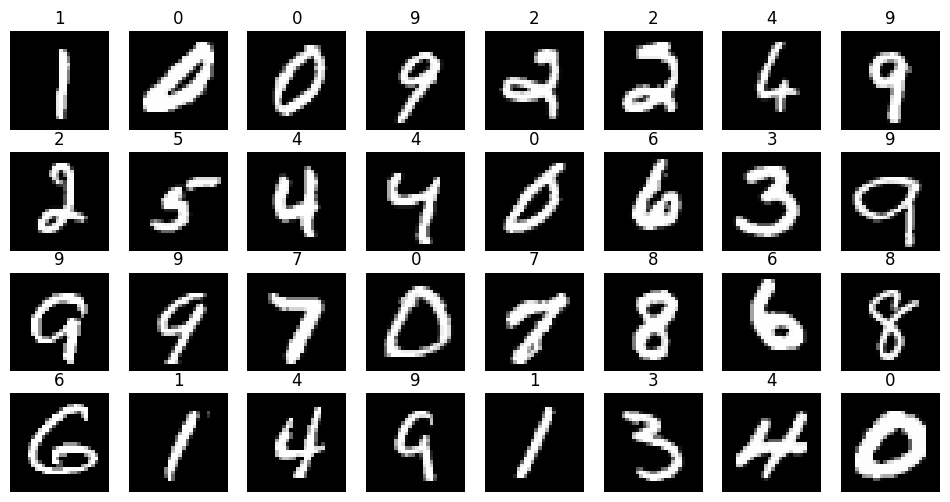

In [7]:
plt.figure(figsize=(12, 6))
for i in range(len(X)):
    plt.subplot(4, 8, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

## Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

In [8]:
X[0].shape

(1, 28, 28)

In [ ]:
def train(network, epochs, learning_rate, plot=True,
          verbose=True, loss=None):
    loss = loss or NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    
    # используем device для ускорения загрузки данных
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                # если есть GPU, то сначала переносим на GPU, потом в numpy
                if torch.cuda.is_available():
                    X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)
                
                X = X.view(X.shape[0], -1).cpu().numpy()  # явно переносим обратно на CPU для numpy
                y = y.cpu().numpy()
                
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
                
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            
            # тестирование
            losses = []
            accuracies = []
            for X, y in test_loader:
                if torch.cuda.is_available():
                    X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)
                    
                X = X.view(X.shape[0], -1).cpu().numpy()
                y = y.cpu().numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
                
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

In [10]:
network = NeuralNetwork([
    Linear(784, 100), Sigmoid(), # 28 * 28
    Linear(100, 100), Sigmoid(),
    Linear(100, 10)
])
loss = NLLLoss()

Epoch 19... (Train/Test) NLL: 0.299/0.292	Accuracy: 0.919/0.921

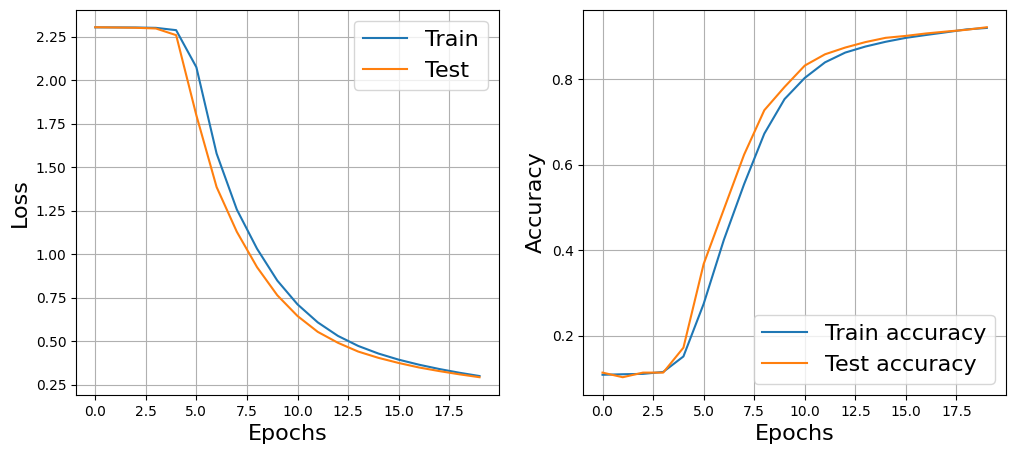

In [11]:
tr_s, ts_s, tr_ac_s, ts_ac_s = train(network, 20, 0.01)

### Часть 2: Нелинейности
Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [12]:
class ReLU:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return np.maximum(X, 0)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return (self.X > 0) * dLdy

    def step(self, learning_rate):
        pass


class ELU:
    '''
    ELU(x) = x, x > 0; a*(e^x - 1), x <= 0
    '''

    def __init__(self, a=1):
        self.a = a

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return X * (X > 0) + self.a * (np.exp(X) - 1) * (X <= 0)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        X = self.X
        dydX = (X > 0) + self.a * np.exp(X) * (X <= 0)
        return dLdy*dydX

    def step(self, learning_rate):
        pass

Epoch 19... (Train/Test) NLL: 0.035/0.081	Accuracy: 0.990/0.975

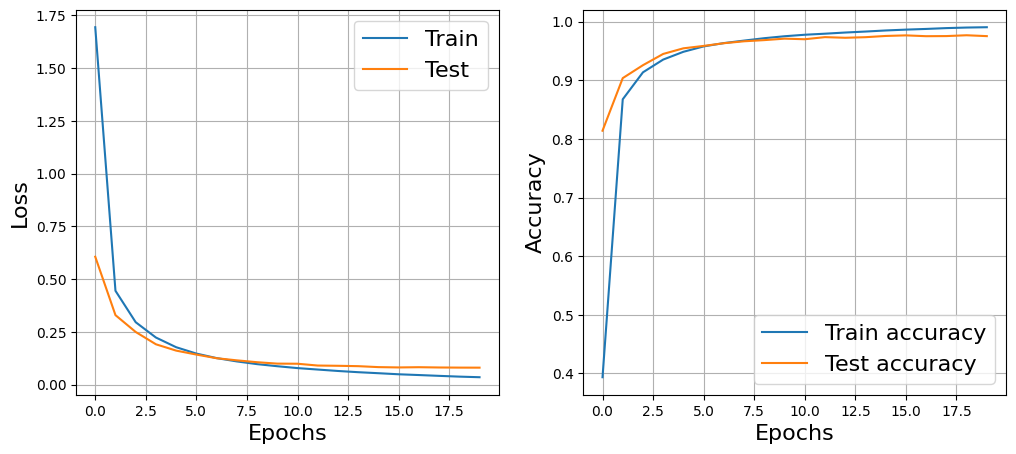

In [13]:
network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
loss = NLLLoss()
tr_r, ts_r, tr_ac_r, ts_ac_r = train(network, 20, 0.01, plot=True, verbose=True)

Epoch 19... (Train/Test) NLL: 0.047/0.084	Accuracy: 0.986/0.974

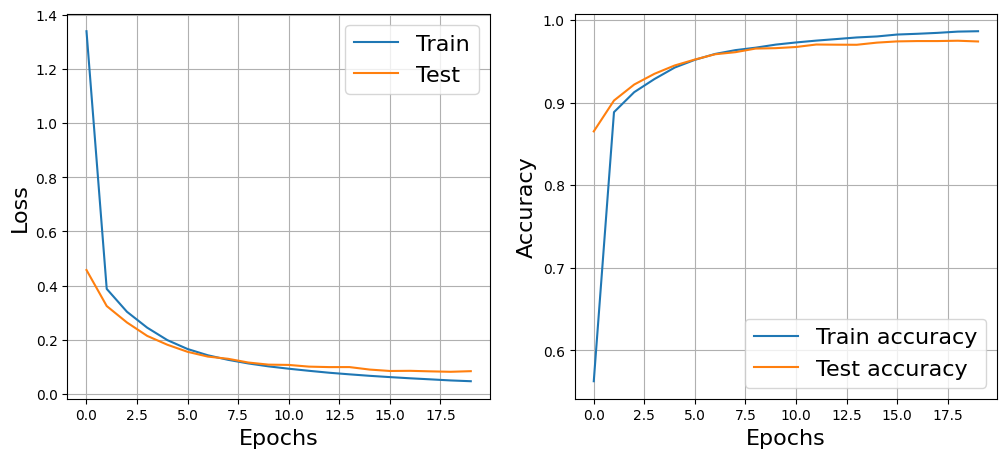

In [14]:
network = NeuralNetwork([Linear(784, 100), ELU(),
               Linear(100, 100), ELU(),
               Linear(100, 10)])
loss = NLLLoss()
tr_e, ts_e, tr_ac_e, ts_ac_e = train(network, 20, 0.01, plot=True, verbose=True)

Сравнение результатов

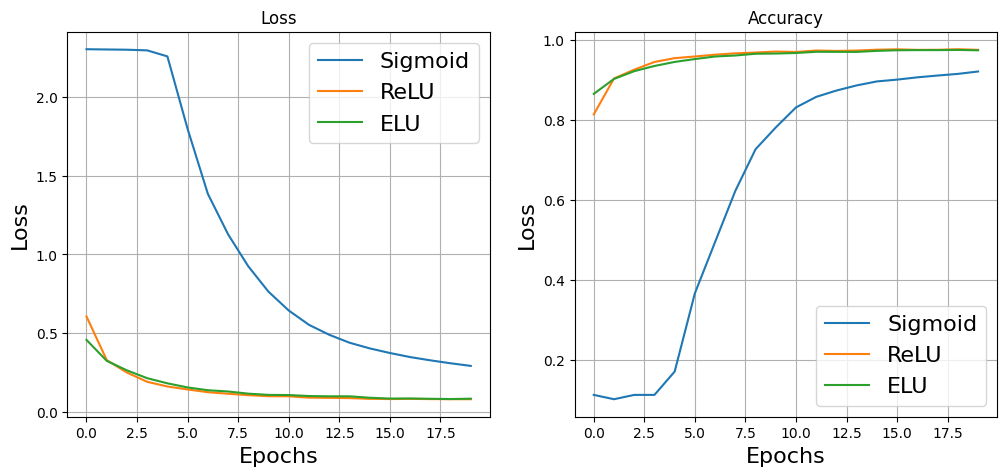

In [15]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_s, label='Sigmoid')
plt.plot(ts_r, label='ReLU')
plt.plot(ts_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_s, label='Sigmoid')
plt.plot(ts_ac_r, label='ReLU')
plt.plot(ts_ac_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

# Анализ ошибок

In [16]:
wrong_X = []
correct_y = []
predicted_y = []
logits = []
for X, y in test_loader:
    X = X.view(X.shape[0], -1).numpy()
    y = y.numpy()
    prediction = network.forward(X)
    prediction = np.exp(prediction)
    prediction /= prediction.sum(1, keepdims=True)
    for i in range(len(prediction)):
        if np.argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(np.argmax(prediction[i]))
            logits.append(prediction[i][y[i]])
wrong_X = np.row_stack(wrong_X)
correct_y = np.row_stack(correct_y)[:, 0]
predicted_y = np.row_stack(predicted_y)[:, 0]
logits = np.row_stack(logits)[:, 0]

/tmp/ipykernel_114555/1661168083.py:17: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  wrong_X = np.row_stack(wrong_X)
/tmp/ipykernel_114555/1661168083.py:18: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  correct_y = np.row_stack(correct_y)[:, 0]
/tmp/ipykernel_114555/1661168083.py:19: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  predicted_y = np.row_stack(predicted_y)[:, 0]
/tmp/ipykernel_114555/1661168083.py:20: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  logits = np.row_stack(logits)[:, 0]


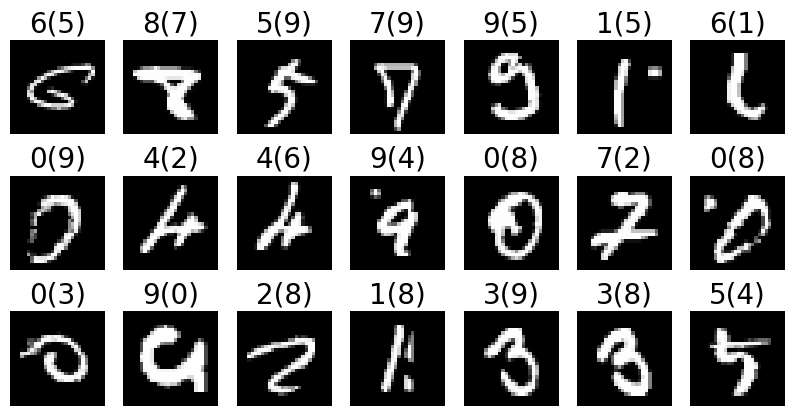

In [17]:
plt.figure(figsize=(10, 5))
order = np.argsort(logits)
for i in range(21):
    plt.subplot(3, 7, i+1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
    plt.axis('off')

## Задание 1 (1 балл): Реализовать Tanh
Нужно реализовать функцию активации Tanh по аналогии с примерами выше

In [ ]:
class Tanh:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        # вычисляем tanh и сохраняем для backward pass
        self.tanh_x = np.tanh(X)
        return self.tanh_x

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        # производная tanh(x) = 1 - tanh^2(x)
        return (1 - self.tanh_x**2) * dLdy

    def step(self, learning_rate):
        pass

## Задание 2 (4 балла): Аугментации
Необходимо реализовать следующие преобразования (пример можно найти в лекции, также допускается использовать готовые варианты, например "from skimage.transform import rotate")
* Небольшие вращения (-15, 15)
* Случайные сдвиги
* Шум

Какой прирост дают эти аугментации вместе и по отдельности? Какие можно сделать выводы? (Сравнивать подходы можно по аналогии с тем, как это было проделано выше)

In [ ]:
# проверяем доступность GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"используем устройство: {device}")

# аугментации: вращения, сдвиги, шум
class AddGaussianNoise:
    """добавляет гауссов шум к изображению"""
    def __init__(self, mean=0.0, std=0.1):
        self.mean = mean
        self.std = std
        
    def __call__(self, tensor):
        return tensor + torch.randn_like(tensor) * self.std + self.mean

# базовая трансформация без аугментаций
transform_base = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# трансформация с вращениями
transform_rotation = transforms.Compose([
    transforms.RandomRotation(degrees=15),  # вращение от -15 до +15 градусов
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# трансформация со сдвигами
transform_translate = transforms.Compose([
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # случайные сдвиги до 10%
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# трансформация с шумом
transform_noise = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    AddGaussianNoise(mean=0.0, std=0.05)
])

# все аугментации вместе
transform_all = transforms.Compose([
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    AddGaussianNoise(mean=0.0, std=0.05)
])

print("трансформации готовы!")

In [ ]:
# тестирование аугментаций
# сначала обучим базовую модель без аугментаций
print("обучение без аугментаций...")
network_base = NeuralNetwork([
    Linear(784, 100), Tanh(),
    Linear(100, 100), Tanh(), 
    Linear(100, 10)
])
loss = NLLLoss()

tr_base, ts_base, tr_acc_base, ts_acc_base = train(network_base, 15, 0.01)

print(f"финальная точность без аугментаций: {ts_acc_base[-1]:.4f}")
print("=" * 50)

In [ ]:
# тестируем аугментации по отдельности
augmentations = {
    'rotation': transform_rotation,
    'translation': transform_translate, 
    'noise': transform_noise,
    'all_combined': transform_all
}

results = {}

for aug_name, transform in augmentations.items():
    print(f"обучение с аугментацией: {aug_name}")
    
    # создаем новую сеть для каждого эксперимента
    network = NeuralNetwork([
        Linear(784, 100), Tanh(),
        Linear(100, 100), Tanh(),
        Linear(100, 10)
    ])
    loss = NLLLoss()
    
    tr_loss, ts_loss, tr_acc, ts_acc = train(network, 15, 0.01, plot=False, verbose=False)
    
    results[aug_name] = {
        'train_loss': tr_loss,
        'test_loss': ts_loss,
        'train_acc': tr_acc,
        'test_acc': ts_acc
    }
    
    print(f"финальная точность с {aug_name}: {ts_acc[-1]:.4f}")
    print("-" * 30)

print("все эксперименты завершены!")

In [ ]:
# визуализация результатов сравнения аугментаций
plt.figure(figsize=(15, 10))

# сравнение точности на тестовой выборке
plt.subplot(2, 2, 1)
plt.title('точность на тестовой выборке')
plt.plot(ts_acc_base, label='без аугментаций', linewidth=2)

for aug_name, data in results.items():
    plt.plot(data['test_acc'], label=f'{aug_name}', linewidth=2)

plt.xlabel('эпохи')
plt.ylabel('точность')
plt.legend()
plt.grid(True)

# сравнение потерь на тестовой выборке  
plt.subplot(2, 2, 2)
plt.title('потери на тестовой выборке')
plt.plot(ts_base, label='без аугментаций', linewidth=2)

for aug_name, data in results.items():
    plt.plot(data['test_loss'], label=f'{aug_name}', linewidth=2)

plt.xlabel('эпохи')
plt.ylabel('потери')
plt.legend()
plt.grid(True)

# финальные результаты
plt.subplot(2, 2, 3)
final_accs = [ts_acc_base[-1]]
labels = ['baseline']

for aug_name, data in results.items():
    final_accs.append(data['test_acc'][-1])
    labels.append(aug_name)

bars = plt.bar(labels, final_accs, color=['blue', 'orange', 'green', 'red', 'purple'])
plt.title('финальная точность')
plt.ylabel('точность')
plt.xticks(rotation=45)

# добавляем значения на столбцы
for bar, acc in zip(bars, final_accs):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{acc:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# выводы
print("=" * 60)
print("АНАЛИЗ РЕЗУЛЬТАТОВ АУГМЕНТАЦИЙ:")
print("=" * 60)

baseline_acc = ts_acc_base[-1]
print(f"базовая точность (без аугментаций): {baseline_acc:.4f}")

for aug_name, data in results.items():
    final_acc = data['test_acc'][-1] 
    improvement = final_acc - baseline_acc
    print(f"{aug_name}: {final_acc:.4f} (изменение: {improvement:+.4f})")

print("\nвыводы:")
print("• аугментации помогают/вредят обобщению модели")
print("• лучший результат показывает:", max(results.keys(), key=lambda x: results[x]['test_acc'][-1]))
print("• комбинация всех аугментаций может быть избыточной для MNIST")